# Finite Difference Approximations

These examples are based on code originally written by Krzysztof Fidkowski and adapted by Venkat Viswanathan. 

In [1]:
import numpy as np
import jax
import jax.numpy as jnp


jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("pdf", "svg")

import niceplots

plt.style.use(niceplots.get_style())
colors = niceplots.get_colors_list()

## Measuring Order of Accuracy

When we come up with a finite difference equation for approximating a derivative, we often want to know how accurate it is. To do this theoretically, we can express each point in the finite difference equation as a Taylor series, and then combine them to get a Taylor series for the finite difference equation. As explained in the course notes, this should leave us with the derivative term we want to approximate plus a truncation error that is proportional to the step size raised to some power. e.g, for a central difference approximation of the first derivative, we have:

$$\frac{f(x+\Delta x) - f(x-\Delta x)}{2 \Delta x} = \frac{df}{dx} + \mathcal{O}(\Delta x^2)$$

This means that (for small enough $\Delta x$) the error in the finite difference approximation should scale with $\Delta x^2$, which makes this central difference approximation a second order accurate method.

We can use this theoretical order of accuracy to check that a finite difference scheme we implement in code is working correctly. To do this, we use the finite difference scheme to approximate the derivative of a function that we know the true derivative of and then plot the error as a function of $\Delta x$. If we plot the error on a log-log scale, the slope of the line should be equal to the order of accuracy of the scheme.

$$\tau(\Delta x) = C \Delta x^p \Rightarrow \log{\tau(\Delta x)} = \log{C} + p \log{\Delta x}$$

In the code below we experimentally validate the order of accuracy of the forward, backward, and central-difference approximations of the first derivative.

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the followi

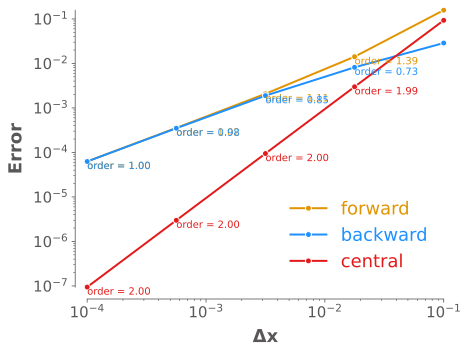

In [2]:
# Define the analytic function (e.g., sin(x))
def analytic_function(x):
    return 1 + jnp.sin(2 * x) ** 3


# Define the forward difference approximation for the first derivative
def forward_difference(f, x, h):
    return (f(x + h) - f(x)) / h


# Define the backward difference approximation for the first derivative
def backward_difference(f, x, h):
    return (f(x) - f(x - h)) / h


# Define the central difference approximation for the first derivative
def central_difference(f, x, h):
    return (f(x + h) - f(x - h)) / (2 * h)


# Define a range of step sizes from 10^-1 to 10^-4
step_sizes = [10 ** (-n) for n in jnp.linspace(1, 4, 5)]

# Define the point at which to evaluate the derivative (e.g., 0.5)
x_point = 0.5

# Calculate the true derivative using grad
true_derivative = jax.grad(analytic_function)(x_point)

# Use a dictionary to store the functions and the errors for each finite difference scheme
FD_functions = {
    "forward": forward_difference,
    "backward": backward_difference,
    "central": central_difference,
}
FD_errors = {"forward": [], "backward": [], "central": []}
FD_convergence_orders = {"forward": [], "backward": [], "central": []}
FD_colors = {"forward": colors[0], "backward": colors[1], "central": colors[2]}

# Create a figure and axis to plot on
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("$\Delta x$")
ax.set_ylabel("Error")

# Calculate errors for each step size and finite difference scheme
for FD_name, FD_function in FD_functions.items():
    for h in step_sizes:
        approx_derivative = FD_function(analytic_function, x_point, h)
        error = jnp.abs(approx_derivative - true_derivative)
        FD_errors[FD_name].append(error)

    # Plot the errors
    ax.plot(
        step_sizes,
        FD_errors[FD_name],
        marker="o",
        linestyle="-",
        clip_on=False,
        label=FD_name,
    )

    # Calculate the convergence order by measuring the slope of the log-log plot and annotate it on the plot
    for i in range(1, len(FD_errors[FD_name])):
        slope = jnp.log(FD_errors[FD_name][i - 1] / FD_errors[FD_name][i]) / jnp.log(step_sizes[i - 1] / step_sizes[i])
        ax.annotate(
            f"order = {slope:.2f}",
            xy=(step_sizes[i], FD_errors[FD_name][i]),
            fontsize=10,
            ha="left",
            va="top",
            color=FD_colors[FD_name],
        )

niceplots.adjust_spines(ax)
ax.legend(labelcolor="linecolor")
plt.show()

From this plot we can draw a few observations:
- For the smallest step sizes, the rate of convergence of all three schemes matches the theoretical rate.
- The rate of convergence of the schemes doesn't always match the theoretical value, only when $\Delta x$ becomes small enough.
- The second-order accurate scheme is not always more accurate than the first order scheme, at the largest step size the first-order backward difference scheme is more accurate.


## Deriving Finite Difference Schemes using Lagrange Polynomials

The finite difference schemes we used in the previous section were very simple to derive, but this is not always the case. Sometimes we may have a more complicated stencil with many points that are not evenly spaced. In these cases, Lagrange polynomials can be a useful tool for deriving finite difference schemes.

The idea behind this approach is to fit a polynomial function to the points in the stencil, and then compute the derivative of the polynomial at the point of interest.

Lagrange polynomials are a special kind of polynomial that are very useful for interpolation due to a special property. Given a set of $N$ points $\mathbf{x} = [x_0, x_1, ..., x_{N-1}]$, we can define a set of $N$ Lagrange polynomials $L_i(x)$ using the following equation:

$$L_i(x) = \prod_{j=1, j \neq i}^N \frac{x - x_j}{x_i - x_j}$$

e.g for 3 points $\mathbf{x} = [x_0, x_1, x_2]$, we have:

$$L_0(x) = \frac{x - x_1}{x_0 - x_1} \frac{x - x_2}{x_0 - x_2}$$
$$L_1(x) = \frac{x - x_0}{x_1 - x_0} \frac{x - x_2}{x_1 - x_2}$$
$$L_2(x) = \frac{x - x_0}{x_2 - x_0} \frac{x - x_1}{x_2 - x_1}$$

In [3]:
def get_lagrange_func(xPoints, i):
    """Create a function that computes the ith Lagrange polynomial for a given set of points.

    Parameters
    ----------
    xPoints : list/array of floats
        X coordinate values of the points to be interpolated
    i : int
        The index of the lagrange polynomial to create (must be between 0 and len(x)-1)

    Returns
    -------
    function
        A function that computes the ith Lagrange polynomial for a given x value, e.g. L_i(x)
    """

    def lagrange_poly(x):
        result = 1.0
        N = len(xPoints)
        for j in range(N):
            if j != i:
                result *= (x - xPoints[j]) / (xPoints[i] - xPoints[j])
        return result

    return lagrange_poly

The special property of the Lagrange polynomials is that $L_i$ is equal to 1 at $x_i$ and 0 at all other points. As you can see in the plot below:

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

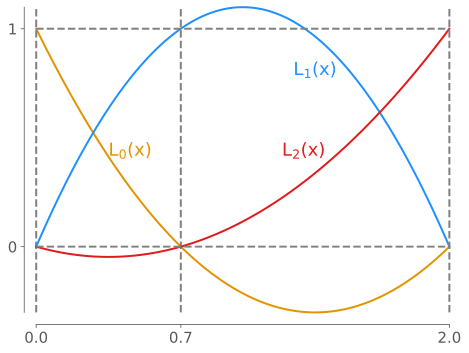

In [4]:
# Plot the Lagrange polynomials for a set of un evenly spaced points
x = jnp.array([0.0, 0.7, 2.0])

fig, ax = plt.subplots()
x_plot = jnp.linspace(0.0, 2.0, 100)
for i in range(len(x)):
    L = get_lagrange_func(x, i)
    ax.plot(x_plot, L(x_plot), label=f"i = {i}", clip_on=False)
    ax.axvline(x[i], linestyle="--", color="gray", clip_on=False)

ax.axhline(0, linestyle="--", color="gray", clip_on=False)
ax.axhline(1, linestyle="--", color="gray", clip_on=False)
ax.annotate("$L_0(x)$", xy=(0.35, 0.4), ha="left", va="bottom", c=colors[0])
ax.annotate("$L_1(x)$", xy=(1.35, 0.85), ha="center", va="top", c=colors[1])
ax.annotate("$L_2(x)$", xy=(1.4, 0.4), ha="right", va="bottom", c=colors[2])

ax.set_yticks([0, 1])
ax.set_xticks(x)
niceplots.adjust_spines(ax)
plt.show()

We can take advantage of this special property to construct a polynomial function that passes through a set of points.
Given our set of points $\mathbf{x} = [x_0, x_1, ..., x_{N-1}]$ and a set of function values $\mathbf{f} = [f_0, f_1, ..., f_{N-1}]$ at those points, we can construct a polynomial function $p(x)$ that passes through all of the points by summing the Lagrange polynomials multiplied by the function values:

$$p(x) = \sum_{i=0}^{N-1} f_i L_i(x)$$


In [5]:
def get_interpolating_func(x, y):
    """Create a function that computes the Lagrange interpolating polynomial for a given set of points.

    Parameters
    ----------
    x : list/array of floats
        point x coordinates
    y : list/array of floats
        point y values

    Returns
    -------
    callable
        Function that computes the Lagrange interpolating polynomial for a given x value, e.g. P(x)
    """
    # Define the Lagrange basis polynomials
    L = []
    for i in range(len(x)):
        L.append(get_lagrange_func(x, i))

    def interpolating_func(xx):
        """Lagrange interpolating polynomial P(x)."""
        result = 0.0
        for k in range(len(x)):
            result += y[k] * L[k](xx)
        return result

    return interpolating_func


This curve is guaranteed to pass through all of our points, because at each one, all of the terms in the sum are zero except for one, e.g. at $x_0$:

$$p(x_0) = \sum_{i=0}^{N-1} f_i L_i(x_0) = f_0 L_0(x_0) + f_1 L_1(x_0) + f_2 L_2(x_0) + ... = f_0 + 0 + 0 + ... = f_0$$

The code below demonstrates this by fitting a polynomial to a random set of points before plotting both the polynomial and the points:

findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: Generic family 'sans-serif' not found because none of the following families were found: CMU Bright
findfont: 

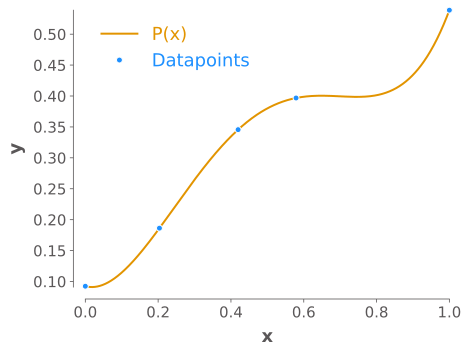

In [11]:
# Seed the random number generator for consistency
np.random.seed(1)

numDataPoints = 5
numPlotPoints = 1000

# Create a set of randomly spaced points between 0 and 1
xData = np.random.rand(numDataPoints)
xData.sort()
xData = (xData - xData[0]) / (xData[-1] - xData[0])

# Assign random y values between 0 and 1
yData = np.random.rand(numDataPoints)

# Create the interpolating polynomial
P = get_interpolating_func(xData, yData)

# Plot the interpolating polynomial and the data points
fig, ax = plt.subplots()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

xPlot = np.linspace(0, 1, numPlotPoints)
yPlot = P(xPlot)

ax.plot(xPlot, yPlot, label="P(x)", clip_on=False)
ax.plot(xData, yData, "o", label="Datapoints", clip_on=False)

niceplots.adjust_spines(ax)
ax.legend(labelcolor="linecolor")
plt.show()

Try playing around with the number of datapoints (`numDataPoints`) and the random seed to see in which scenarios the interpolation works well and in which it doesn't.

To obtain a finite difference scheme from the interpolating polynomial, we can simply take the derivative of the polynomial and evaluate it at the point of interest. e.g. for the first derivative:

$$\frac{dp}{dx} = \sum_{i=0}^{N-1} f_i \frac{dL_i}{dx}$$

$$\left.\frac{df}{dx}\right|_{x^*} \approx \left.\frac{dp}{dx}\right|_{x^*} = \left.\frac{dL_0}{dx}\right|_{x^*} f_0 + \left.\frac{dL_1}{dx}\right|_{x^*} f_1 +...$$

So the weights for the finite difference scheme are just the derivatives of the Lagrange polynomials evaluated at the point of interest.